# QLM cheatsheet


## Install:

    pip install myqlm
    pip install myqlm-interop
    

## Hello world: create a circuit and execute it

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from qat.lang.AQASM import Program, H, CNOT
prog = Program()
qbits = prog.qalloc(2)
prog.apply(H, qbits[0])
prog.apply(CNOT, qbits)
circ = prog.to_circ()
%jsqatdisplay circ

from qat.qpus import PyLinalg
qpu = PyLinalg()
result = qpu.submit(circ.to_job())
for sample in result:
    print(sample.state, sample.amplitude, sample.probability)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

|00> (0.7071067811865475+0j) 0.4999999999999999
|11> (0.7071067811865475+0j) 0.4999999999999999


## Use a finite number of shots

In [46]:
result = qpu.submit(circ.to_job(nbshots=200))
for sample in result:
    print(sample.state, sample.amplitude, sample.probability, sample.err)

|00> None 0.46 0.03533045720097818
|11> None 0.54 0.03533045720097818


## Use a quantum routine and controls

In [47]:
from qat.lang.AQASM import QRoutine, RX, Y

routine = QRoutine()
reg = routine.new_wires(2)
routine.apply(RX(np.pi/2), reg[0])
routine.apply(Y.ctrl(), reg)

prog = Program()
qbits = prog.qalloc(3)
prog.apply(routine, qbits[0:2])
prog.apply(routine, qbits[1:3])
prog.apply(routine.ctrl(), qbits)
circ = prog.to_circ()
%jsqatdisplay circ

result = qpu.submit(circ.to_job(qubits=qbits))
for sample in result:
    print(sample.state, sample.probability)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

|000> 0.2500000000000001
|011> 0.2500000000000001
|100> 0.12500000000000006
|101> 0.12500000000000006
|110> 0.12500000000000006
|111> 0.12500000000000006


## Perform a Quantum Fourier transform

In [48]:
from qat.lang.AQASM.qftarith import QFT

prog = Program()
qbits = prog.qalloc(3)
prog.apply(QFT(3), qbits)

circ = prog.to_circ()
%jsqatdisplay circ --d 0

result = qpu.submit(circ.to_job(qubits=qbits))
for sample in result:
    print(sample.state, sample.probability)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

|000> 0.12499999999999994
|001> 0.12499999999999994
|010> 0.12499999999999994
|011> 0.12499999999999994
|100> 0.12499999999999994
|101> 0.12499999999999994
|110> 0.12499999999999994
|111> 0.12499999999999994


## Use several typed qubit registers and measure only one register

In [49]:
from qat.lang.AQASM import QInt
prog = Program()
ancillas = prog.qalloc(1)
qbits = prog.qalloc(2, class_type=QInt)
prog.apply(routine, ancillas[0], qbits[0])
prog.apply(routine, qbits[0:2])

circ = prog.to_circ()
%jsqatdisplay circ

result = qpu.submit(circ.to_job(qubits=qbits))
for sample in result:
    print(sample.state, sample.probability)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

|0> 0.5000000000000002
|3> 0.5000000000000002


## Measure an observable

In [50]:
from qat.core import Observable, Term

observable = Observable(1, pauli_terms=[Term(1.0, "Z", [0])])

prog = Program()
qbits = prog.qalloc(1)
H(qbits)
circ = prog.to_circ()

result = qpu.submit(circ.to_job(observable=observable))
print("<psi|Z|psi> =", result.value)

<psi|Z|psi> = 0.0


## Measure an observable... without cheating

In [51]:

from qat.core import Observable, Term

observable = Observable(1, pauli_terms=[Term(1.0, "Z", [0]), Term(1.0, "Y", [0])])

prog = Program()
qbits = prog.qalloc(1)
H(qbits)
circ = prog.to_circ()

from qat.plugins import ObservableSplitter
splitter = ObservableSplitter()
result = (splitter|qpu).submit(circ.to_job(observable=observable, nbshots=50))
print("<psi|Z|psi> ~ %s +/- %s "%(result.value, result.error))

<psi|Z|psi> ~ -0.27999999999999997 +/- 0.19967320239607028 


## Create a parametric circuit and run a variational computation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precision reached ( 0.0001 ), iteration number = 71
Minimum variational energy: -1.5


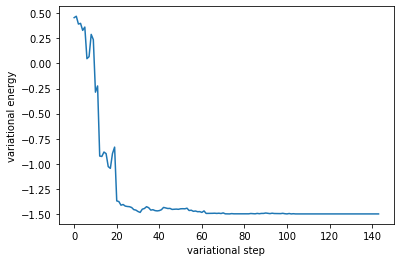

In [52]:
from qat.lang.AQASM import RY
prog = Program()
qbits = prog.qalloc(2)
theta = prog.new_var(float, "\\theta")
H(qbits[0])
CNOT(qbits)
RY(theta)(qbits[0])
circ = prog.to_circ()
%jsqatdisplay circ

observable = Observable(2, pauli_terms=[Term(0.5, "XX", [0, 1]), Term(0.5, "YY", [0, 1]), Term(0.5, "ZZ", [0, 1])])

from qat.plugins import SPSAMinimizePlugin
spsa = SPSAMinimizePlugin(x0=[0.3])
stack = spsa | splitter | qpu

result = stack.submit(circ.to_job(observable=observable, nbshots=1000))
print("Minimum variational energy:", result.value)

plt.plot(eval(result.meta_data["optimization_trace"]))
plt.ylabel("variational energy")
plt.xlabel("variational step");

## Run a noisy simulation with depolarizing noise

Minimum variational energy: -1.3744999999999998


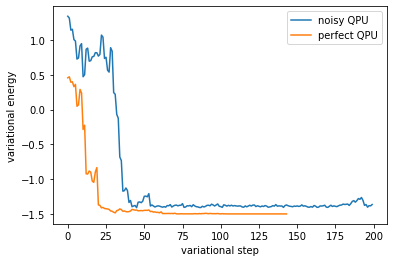

In [53]:
from depolarizing_plugin_vec import DepolarizingPluginVec
plugin = DepolarizingPluginVec(prob_1qb=0.01, prob_2qb=0.02)
from qat.qpus import PyLinalg
qpu = PyLinalg()
noisy_qpu = plugin | qpu
from qat.plugins import ScipyMinimizePlugin
from qat.plugins import ObservableSplitter
splitter = ObservableSplitter()
spsa = SPSAMinimizePlugin(x0=[0.3])
scipy = ScipyMinimizePlugin(x0=[0.3])
noisy_stack = scipy | noisy_qpu
noisy_stack = spsa | splitter | noisy_qpu
#noisy_stack = spsa | splitter | qpu

noisy_result = noisy_stack.submit(circ.to_job(observable=observable, nbshots=1000))
print("Minimum variational energy:", noisy_result.value)

plt.plot(eval(noisy_result.meta_data["optimization_trace"]), label="noisy QPU")
plt.plot(eval(result.meta_data["optimization_trace"]), label="perfect QPU")
plt.legend(loc="best")
plt.ylabel("variational energy")
plt.xlabel("variational step");